In [7]:
# Import Libraries
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

# Define Paths
dataset_dir = "Data"  # Root folder containing class folders
# Adjust class names to match actual folder names
classes = ["Mild Dementia", "Moderate Dementia", "Non Demented", "Very Mild Dementia"]

# Load Data with Correct Folder Names
image_paths, labels = [], []
for class_label, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        print(f"Error: Folder {class_dir} does not exist.")
        continue
    files = glob.glob(f"{class_dir}/*.jpg")  # Adjust extension if needed
    print(f"Class: {class_name}, Files Found: {len(files)}")  # Debug: Count files
    for file_path in files:
        image_paths.append(file_path)
        labels.append(class_label)

# Proceed with the pipeline if files are found
if len(image_paths) == 0:
    raise ValueError("No images found. Check dataset folder names or file paths.")

# Split Dataset
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Total images: {len(image_paths)}")
print(f"Training images: {len(train_paths)}, Testing images: {len(test_paths)}")


Class: Mild Dementia, Files Found: 5002
Class: Moderate Dementia, Files Found: 488
Class: Non Demented, Files Found: 67222
Class: Very Mild Dementia, Files Found: 13725
Total images: 86437
Training images: 69149, Testing images: 17288


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer

# Normalize image paths and labels
train_paths = np.array(train_paths)
test_paths = np.array(test_paths)

# One-hot encode the labels
label_binarizer = LabelBinarizer()
train_labels = label_binarizer.fit_transform(train_labels)
test_labels = label_binarizer.transform(test_labels)

# Preprocessing Function for Images
IMG_HEIGHT, IMG_WIDTH = 224, 224

def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Load Dataset
def load_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: (preprocess_image(x), y))
    return dataset

# Prepare Train and Test Datasets
train_dataset = load_dataset(train_paths, train_labels)
test_dataset = load_dataset(test_paths, test_labels)

# Batch and Shuffle the Datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [9]:
from tensorflow.keras import layers, models

def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(len(classes), activation='softmax')  # Number of classes
    ])
    return model

model = build_model()
model.summary()


c:\Users\aritt\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
EPOCHS = 10
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS
)

# Save the Model
model.save("alzheimers_detection_model.h5")


541/541 ━━━━━━━━━━━━━━━━━━━━ 193s 350ms/step - accuracy: 1.0000 - loss: 2.6438e-04
Test Loss: 0.0002, Test Accuracy: 1.0000


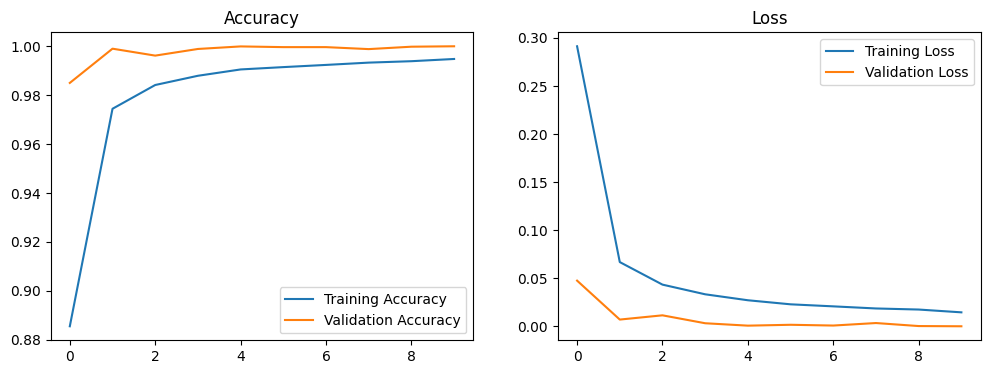

In [5]:
# Evaluate the Model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Plot Accuracy and Loss
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(12, 4))
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

plot_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Predicted Class: 3


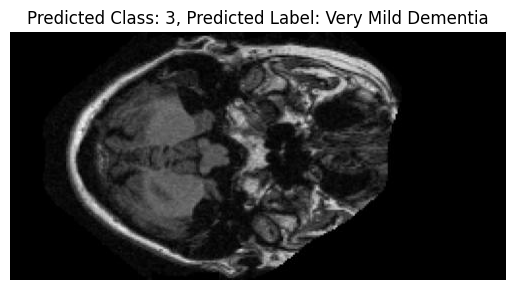

In [10]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the Saved Model
loaded_model = load_model("Alzheimers/alzheimers_detection_model.h5")

# Testing on a Single Image
test_image_path = r'Data\Very mild Dementia\OAS1_0003_MR1_mpr-1_116.jpg' # Replace with actual image path
test_image = preprocess_image(test_image_path)
test_image = tf.expand_dims(test_image, axis=0)  # Adding batch dimension

prediction = loaded_model.predict(test_image)
predicted_class = label_binarizer.inverse_transform(prediction)[0]
print(f"Predicted Class: {predicted_class}")

if predicted_class==0:
    pred_label="Mild Dementia"
elif predicted_class==1:
    pred_label="Moderate Dementia"
elif predicted_class==2:
    pred_label="Non Demented"
else:
    pred_label="Very Mild Dementia"

# Display Image + Prediction
plt.imshow(plt.imread(test_image_path))
plt.title(f"Predicted Class: {predicted_class}, Predicted Label: {pred_label}")
plt.axis('off')
plt.show()


In [11]:
model=load_model('Alzheimers/alzheimers_detection_model.h5')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,478 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

541/541 ━━━━━━━━━━━━━━━━━━━━ 273s 503ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00      1000
 Moderate Dementia       1.00      1.00      1.00        98
      Non Demented       1.00      1.00      1.00     13445
Very Mild Dementia       1.00      1.00      1.00      2745

          accuracy                           1.00     17288
         macro avg       1.00      1.00      1.00     17288
      weighted avg       1.00      1.00      1.00     17288



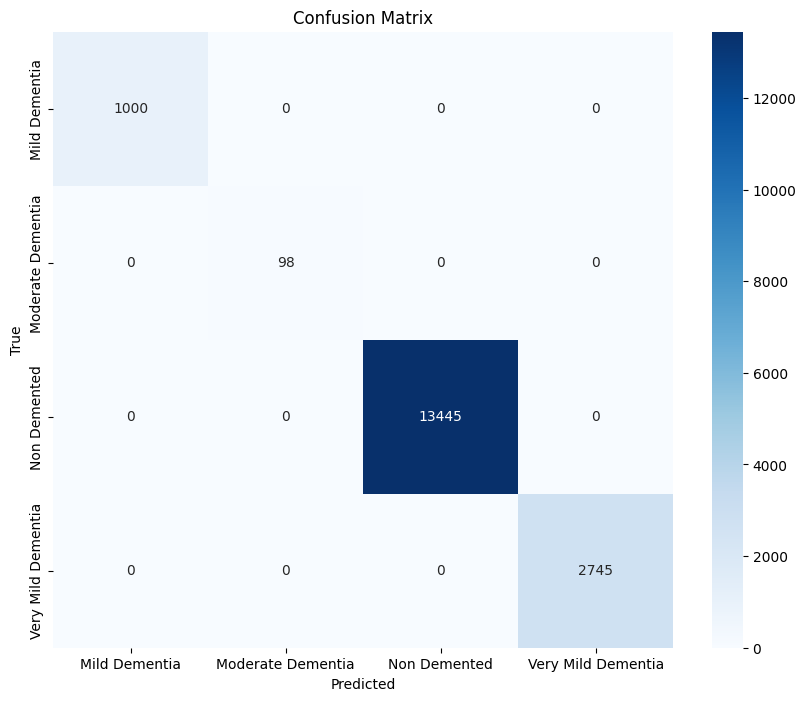

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Get true labels and predictions
y_true = np.argmax(test_labels, axis=1)
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)

# Classification Report
class_names = classes
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()